Importing all the needed packages

In [20]:
from tqdm import tqdm
import winsound
import numpy as np
import pylab as pl
import astropy.units as u
from galpy.orbit import Orbit
import galpy.util.coords as coords
from galpy.potential import MWPotential2014
from galpy.potential import McMillan17

Creating the velocity ellipsoid for white dwarfs (Table 2 from [Torres et al. 2019, MNRAS, 485, 5573-5589](https://ui.adsabs.harvard.edu/abs/2019MNRAS.485.5573T/abstract)), then plotting a random selection of velocities in a Toomre diagram, and convering one for each into cylindrical coordinates:

[ 24.20458169 -17.05396411  23.55366778]
[ -7.29548385   6.70538266 -24.73367077]
[  -0.80011932 -158.23947281   25.92345408]


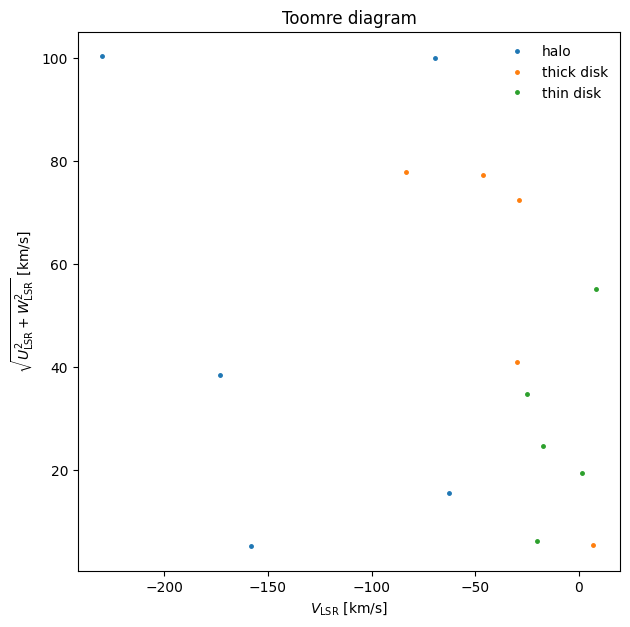

In [21]:
N = 10 #Number of WD of each class (thin, thick, halo)

# velocity ellipsoid
#UVW_thin = np.array([[2.5,22.5],[-1.4,17.4],[0,0]])
UVW_thin = np.array([[2.5,22.5],[-1.4,17.4],[2.6,16.2]])
UVW_thick = np.array([[-18.6,50.4],[-30.0,29.3],[1.1,33.1]])
UVW_halo = np.array([[-27.3,100.8],[-92.3,67.4],[3.4,66.9]])

nUVW_thin = np.random.normal(UVW_thin[:,0],UVW_thin[:,1],(N,3))
nUVW_thick = np.random.normal(UVW_thick[:,0],UVW_thick[:,1],(N,3))
nUVW_halo = np.random.normal(UVW_halo[:,0],UVW_halo[:,1],(N,3))

print(nUVW_thin[0])
print(nUVW_thick[0])
print(nUVW_halo[0])

fig = pl.figure(figsize=(7,7))
fig.subplots_adjust(wspace=0.3)
ax1 = fig.add_subplot(111)

ax1.set_title("Toomre diagram")
ax1.plot(nUVW_halo[:,1],np.sqrt(nUVW_halo[:,0]**2 + nUVW_halo[:,2]), marker='.', ms=5, ls='none', label='halo')
ax1.plot(nUVW_thick[:,1],np.sqrt(nUVW_thick[:,0]**2 + nUVW_thick[:,2]), marker='.', ms=5, ls='none', label='thick disk')
ax1.plot(nUVW_thin[:,1],np.sqrt(nUVW_thin[:,0]**2 + nUVW_thin[:,2]), marker='.', ms=5, ls='none', label='thin disk')

ax1.set_xlabel(r'$V_{\rm LSR}$ [km/s]')
ax1.set_ylabel(r'$\sqrt{U^2_{\rm LSR} + W^2_{\rm LSR}}$ [km/s]')

pl.legend(frameon=False)


pl.show()


# A spatial distribution is created
XYZ = [8.030,0.0,0.025] # Center of the spatial distribution Kpc

rand3 = np.random.rand(N)
rand4 = np.random.rand(N)
rand5 = np.random.rand(N)

R= 0.1 # 100 parsecs
phi = 2*180*rand3 #
theta = np.arccos(2*rand4-1)
r = R*np.cbrt(rand5)

x = r*np.sin(theta)*np.cos(phi) + XYZ[0]
y = r*np.sin(theta)*np.sin(phi) + XYZ[1]
z = r*np.cos(theta) + XYZ[2]


RTZ_thin = np.transpose(coords.rect_to_cyl(x, y, z))
vRTZ_thin = np.transpose(coords.rect_to_cyl_vec(nUVW_thin[:,0], nUVW_thin[:,1],nUVW_thin[:,2], x, y, z ,cyl=False))

RTZ_thick = np.transpose(coords.rect_to_cyl(x, y, z))
vRTZ_thick = np.transpose(coords.rect_to_cyl_vec(nUVW_thick[:,0],nUVW_thick[:,1],nUVW_thick[:,2],x, y,z , cyl=False))

RTZ_halo = np.transpose(coords.rect_to_cyl(x, y, z))
vRTZ_halo = np.transpose(coords.rect_to_cyl_vec(nUVW_halo[:,0],nUVW_halo[:,1],nUVW_halo[:,2], x, y, z, cyl=False)) # que significa cyl


We create three orbits for thin-disk, thick-disk, and halo white dwarfs, respectively. Then we create an array of timesteps
And finally we integrate the orbits.

In [22]:
from concurrent.futures import ThreadPoolExecutor
R0, z0, V0, v_sun = 8.122*u.kpc, 0.0208*u.kpc, 235.*u.km/u.s, [12.9, 10.6, 7.78]*u.km / u.s

star_thin = np.transpose([RTZ_thin[:,0]/8.,  vRTZ_thin[:,0]/220, 1+vRTZ_thin[:,1]/220,  RTZ_thin[:,2]/8,  vRTZ_thin[:,2]/220,  RTZ_thin[:,1]])

star_thick = np.transpose([RTZ_thick[:,0]/8.,vRTZ_thick[:,0]/220, 1+vRTZ_thick[:,1]/220,RTZ_thick[:,2]/8,vRTZ_thick[:,2]/220,RTZ_thick[:,1]])

star_halo = np.transpose([RTZ_halo[:,0]/8.,vRTZ_halo[:,0]/220, 1+vRTZ_halo[:,1]/220,RTZ_halo[:,2]/8,vRTZ_halo[:,2]/220,RTZ_halo[:,1]])

inicio = 0
fin = 2000
paso = 1e-3
ts = np.arange(inicio, fin + paso, paso, dtype=np.float64)

o_thin = Orbit(star_thin , ro=R0, zo=z0, vo=V0, solarmotion=v_sun)
o_thin.integrate(ts,MWPotential2014)
#o_thin.integrate(ts, McMillan17)

o_thick = Orbit(star_thick, ro=R0, zo=z0, vo=V0, solarmotion=v_sun)
o_thick.integrate(ts,MWPotential2014)
#o_thick.integrate(ts, McMillan17)

o_halo = Orbit(star_halo, ro=R0, zo=z0, vo=V0, solarmotion=v_sun)
o_halo.integrate(ts,MWPotential2014)
#o_halo.integrate(ts, McMillan17)

# printing eccentricity and angular momentum (z component)
# print('e = ', o_thin.e() , 'Lz = ', o_thin.Lz(quantity=True))
# print('e = ', round(o_thick.e(),3), 'Lz = ', o_thick.Lz(quantity=True))
# print('e = ', round(o_halo.e(),3), 'Lz = ', o_halo.Lz(quantity=True))


KeyboardInterrupt: 

In [ ]:

# Play sound when this line is executed
winsound.PlaySound("sound.wav", winsound.SND_FILENAME)
winsound.PlaySound("sound.wav", winsound.SND_FILENAME)
winsound.PlaySound("sound.wav", winsound.SND_FILENAME)

Plotting angluar momentum vs eccentricity

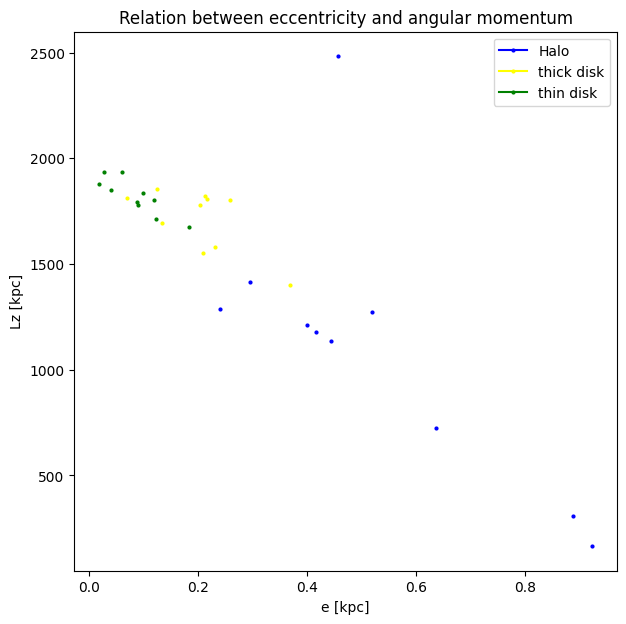

El numero de orbitas retrogradas total es:  0
El numero de orbitas retrogradas del halo es:  0
El numero de orbitas retrogradas del thick es:  0
El numero de orbitas retrogradas del thin es:  0
orbitas retrogradas en el halo entre orbitas retrogradas totales es:  0.0
Estrellas con orbitas retrogradas en el halo:  0.0


In [ ]:
fig = pl.figure(figsize=(7,7))
fig.subplots_adjust(wspace=0.3)
ax1 = fig.add_subplot(111)

cro = 0 #counter_of_retograde_orbits
crho = 0 #counter_of_retograde_orbits_halo
crto = 0 #counter_of_retograde_orbits_thick
crio = 0 #counter_of_retograde_orbits_thin  

o_h_e = o_halo.e()
o_t_e = o_thick.e()
o_ti_e = o_thin.e()
o_h_l = o_halo.Lz()
o_t_l = o_thick.Lz()
o_ti_l = o_thin.Lz()

for i in range(len(o_halo.e())):
    if o_halo.Lz()[i] < 0:
        crho += 1   
        cro += 1
    if o_thick.Lz()[i] < 0: 
        crto += 1
        cro += 1
    if o_thin.Lz()[i] < 0:
        crio += 1
        cro += 1
    
    ax1.plot(o_h_e[i], o_h_l[i], marker='.', ms=4 ,color = 'blue')
    ax1.plot(o_t_e[i], o_t_l[i],  marker='.', ms=4,color = 'yellow')
    ax1.plot(o_ti_e[i], o_ti_l[i], marker='.', ms=4, color='green')


ax1.legend(['Halo', 'thick disk', 'thin disk'])

ax1.set_title("Relation between eccentricity and angular momentum")
ax1.set_xlabel('e [kpc]')
ax1.set_ylabel('Lz [kpc]')


pl.show()

print("El numero de orbitas retrogradas total es: ", cro)
print("El numero de orbitas retrogradas del halo es: ", crho)
print("El numero de orbitas retrogradas del thick es: ", crto)
print("El numero de orbitas retrogradas del thin es: ", crio)
print("orbitas retrogradas en el halo entre orbitas retrogradas totales es: ", crho/(cro+1))
print("Estrellas con orbitas retrogradas en el halo: ", crho/N) 

Compare the relations among orbital parameters (apocentre, pericentre, periods, Zmax, e, Lz) for both the
simulated white dwarfs belonging to the thin- and thick-disk, and halo

In [ ]:

print(np.average(o_halo.e()**2 - 1 + (4*o_halo.rap()*o_halo.rperi())/(o_halo.rap() + o_halo.rperi())**2))
print(np.average(o_thick.e()**2 - 1 + (4*o_thick.rap()*o_thick.rperi())/(o_thick.rap() + o_thick.rperi())**2))
print(np.average(o_thin.e()**2 - 1 + (4*o_thin.rap()*o_thin.rperi())/(o_thin.rap() + o_thin.rperi())**2))





-6.938893903907228e-17
2.2204460492503132e-17
0.0


In [ ]:
# As eccentricity increase the perihcentr is closer to the center of the galaxy and the 
# apocentre is farther away from the center of the galaxy. we should show this relation
#o_thin.zmax()
#o_thin.rperi()
#o_thin.rap()
#o_thin.period?

# lets plot thr apocenter and the period to show the achieve of the third kepler law
# The ratio of the square of an object's orbital period with the
# cube of the semi-major axis of its orbit is the same for all objects orbiting the same primary.

#fig = pl.figure(figsize=(7,7))
#fig.subplots_adjust(wspace=0.3)
#ax = fig.add_subplot(111)
G = 4.302e-3 #pc/Msun(km/s)^2



a_halo = (o_halo.rap()[i] + o_halo.rperi()[i])/2 # semiejemayor #Kpc

a_thin = (o_thin.rap()[i] + o_thin.rperi()[i])/2 # semiejemayor

a_thick = (o_thick.rap()[i] + o_thin.rperi()[i])/2

"""
GMm2_halo = o_halo.Lz()**2 /(a_halo*(1-o_halo.e()**2)) #masa del halo en unidades de masa solar
error = o_halo.E() + GMm2_halo/(2*a_halo) # error de energia    
print(error)
print(np.average(error))
"""

rap_halo = np.average(o_halo.rap())
rap_thin = np.average(o_thin.rap())
rap_thick = np.average(o_thick.rap())
print("Apocentros: ",rap_halo,rap_thin,rap_thick)

rpe_halo = np.average(o_halo.rperi())
rpe_thin = np.average(o_thin.rperi())
rpe_thick = np.average(o_thick.rperi())

print("Pericentros: ", rpe_halo ,rpe_thin , rpe_thick)
"""
    ax.plot(o_halo.period()[i]**2  ,a_halo[i]**3, marker='.', ms=7 ,color = 'blue')
    ax.plot(o_thin.period()[i]**2 ,a_thin[i]**3,  marker='.', ms=7,color = 'yellow')
    ax.plot(o_thick.period()[i]**2 ,a_thick[i]**3, marker='.', ms=7, color='green')
"""
"""
ax.set_title("Third kepler's law")
ax1.set_xlabel('T**2 (orbital period))')
ax1.set_ylabel('a**3 (semimajor axis)')
pl.show()
"""

Apocentros:  10.13781660161746 8.444689321477929 9.10017049704658
Pericentros:  3.4075083339320607 7.156759796423335 6.06513218596072


'\nax.set_title("Third kepler\'s law")\nax1.set_xlabel(\'T**2 (orbital period))\')\nax1.set_ylabel(\'a**3 (semimajor axis)\')\npl.show()\n'

Histograma de la distribución espacial de los objetos 

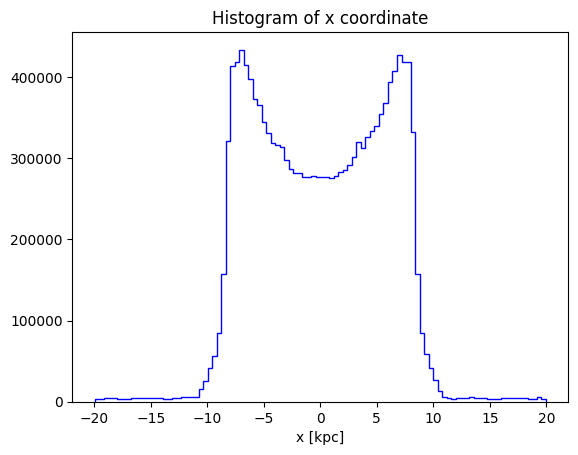

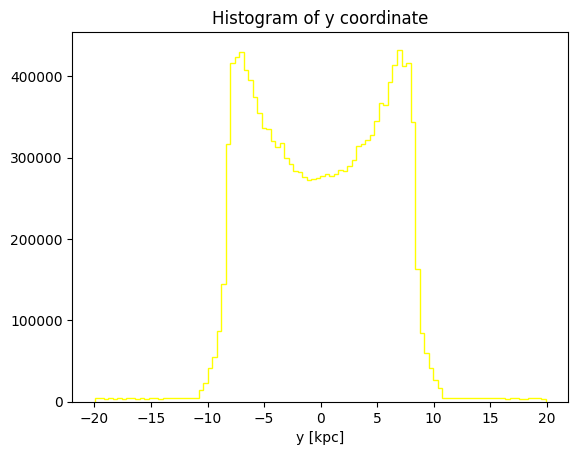

Text(0.5, 0, 'z [kpc]')

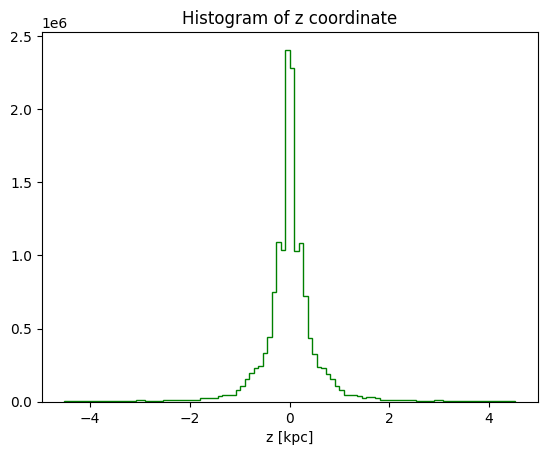

In [ ]:

x_thin = o_thin.x(ts).flatten()
x_thick = o_thick.x(ts).flatten()
x_halo = o_halo.x(ts).flatten()

y_thin = o_thin.y(ts).flatten()
y_thick = o_thick.y(ts).flatten()
y_halo = o_halo.y( ts).flatten()

z_thin = o_thin.z( ts).flatten()
z_thick = o_thick.z(ts).flatten()
z_halo = o_halo.z(ts).flatten()

a = np.concatenate((x_thin,x_thick,x_halo))
b = np.concatenate((y_thin,y_thick,y_halo)) 
c = np.concatenate((z_thin,z_thick,z_halo)) 

pl.hist(a, bins=100, histtype='step', color='blue')
pl.title('Histogram of x coordinate')
pl.xlabel('x [kpc]')
pl.show()

pl.hist(b, bins=100, histtype='step', color='yellow')
pl.title('Histogram of y coordinate')
pl.xlabel('y [kpc]')

pl.show()

pl.hist(c, bins=100, histtype='step', color='green')
pl.title('Histogram of z coordinate')
pl.xlabel('z [kpc]')



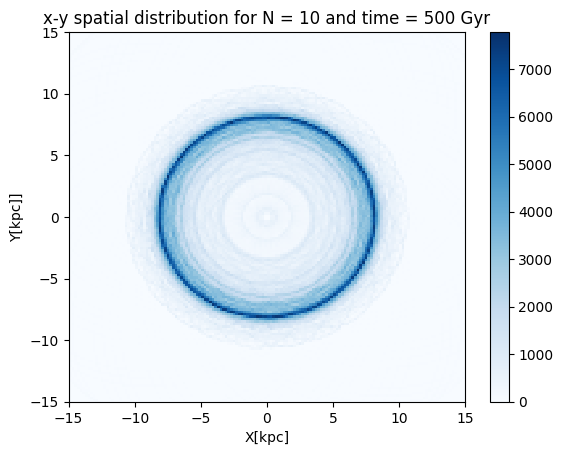

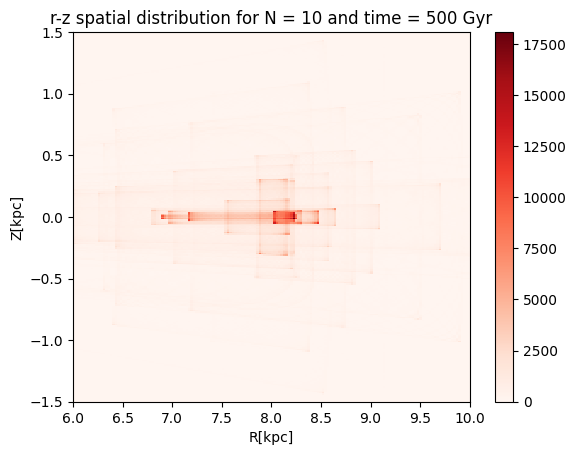

In [ ]:
# Assuming you have two arrays x and y containing the data
bins = 200
pl.hist2d(a, b, bins=bins, cmap='Blues')
pl.xlabel('X[kpc]')
pl.ylabel('Y[kpc]]')
pl.title(f'x-y spatial distribution for N = {N} and time = {fin} Gyr')
pl.colorbar()
pl.xlim(-15, 15)
pl.ylim(-15, 15)
pl.show()

# Histogram for b and c
bins = 800
pl.hist2d((a**2+b**2)**(1/2),c , bins=bins, cmap='Reds')
pl.xlabel('R[kpc]')
pl.ylabel('Z[kpc]')
pl.title(f'r-z spatial distribution for N = {N} and time = {fin} Gyr')
pl.colorbar()
pl.xlim(6, 10)
pl.ylim(-1.5, 1.5)
pl.show()





In [ ]:
# fig = pl.figure(figsize=(14,6))
# fig.subplots_adjust(wspace=0.3)
# ax1 = fig.add_subplot(121)

# for i in range(len(o_halo.R(ts,quantity=True))):

#     ax1.plot(o_halo.R(ts,quantity=True)[i],o_halo.z(ts,quantity=True)[i], color = 'blue')
#     ax1.plot(o_thick.R(ts,quantity=True)[i],o_thick.z(ts,quantity=True)[i], color = 'yellow')
#     ax1.plot(o_thin.R(ts,quantity=True)[i],o_thin.z(ts,quantity=True)[i], color='green')


# ax1.set_xlabel('R [kpc]')
# ax1.set_ylabel('Z [kpc]')


# ax2 = fig.add_subplot(122)

# for i in range(len(o_halo.y())):
#     ax2.plot(o_halo.y(ts,quantity=True)[i],o_halo.x(ts,quantity=True)[i], color = 'blue')
#     ax2.plot(o_thick.y(ts,quantity=True)[i],o_thick.x(ts,quantity=True)[i],  color = 'yellow')
#     ax2.plot(o_thin.y(ts,quantity=True)[i],o_thin.x(ts,quantity=True)[i],  color = 'green')

# ax2.set_xlabel('Y [kpc]')
# ax2.set_ylabel('X [kpc]')
# pl.legend(frameon=False)
# ax2.invert_xaxis()
# ax2.invert_yaxis()

# pl.show()


In [ ]:
# fig = pl.figure(figsize=(5,5))
# fig.subplots_adjust(wspace=0.3)
# ax1 = fig.add_subplot(projection='3d')

# for i in range(len(o_halo.y())):
#     ax1.plot(o_halo.y(ts,quantity=True)[i],o_halo.x(ts,quantity=True)[i], o_halo.x(ts,quantity=True)[i], color='blue')
#     ax1.plot(o_thick.y(ts,quantity=True)[i],o_thick.x(ts,quantity=True)[i], o_thick.x(ts,quantity=True)[i], color='yellow')
#     ax1.plot(o_thin.y(ts,quantity=True)[i],o_thin.x(ts,quantity=True)[i], o_thin.x(ts,quantity=True)[i],color='green')


# ax1.set_xlabel('Y [kpc]')
# ax1.set_ylabel('X [kpc]')
# ax1.set_zlabel('Z [kpc]')

# ax1.invert_xaxis()
# ax1.invert_yaxis()
# pl.show()

Integrating for longer and plotting the orbits

In [ ]:
# ts = np.linspace(0,2,10000)*u.Gyr


# o_thin.integrate(ts,MWPotential2014)

# o_thick.integrate(ts,MWPotential2014)

# o_halo.integrate(ts,MWPotential2014)



# fig = pl.figure(figsize=(14,6))
# fig.subplots_adjust(wspace=0.3)
# ax1 = fig.add_subplot(121)

# for i in range(len(o_halo.R())):
#     ax1.plot(o_halo.R(ts,quantity=True)[i],o_halo.z(ts,quantity=True)[i], color='blue')
#     ax1.plot(o_thick.R(ts,quantity=True)[i],o_thick.z(ts,quantity=True)[i], color='orange')
#     ax1.plot(o_thin.R(ts,quantity=True)[i],o_thin.z(ts,quantity=True)[i], color='green')

# ax1.set_xlabel('R [kpc]')
# ax1.set_ylabel('Z [kpc]')


# ax2 = fig.add_subplot(122)

# for i in range(len(o_halo.R())):  
#     ax2.plot(o_halo.y(ts,quantity=True)[i],o_halo.x(ts,quantity=True)[i], color='blue')
#     ax2.plot(o_thick.y(ts,quantity=True)[i],o_thick.x(ts,quantity=True)[i], color='orange')
#     ax2.plot(o_thin.y(ts,quantity=True)[i],o_thin.x(ts,quantity=True)[i], color='green')

# ax2.set_xlabel('Y [kpc]')
# ax2.set_ylabel('X [kpc]')

# pl.legend(frameon=False)

# ax2.invert_yaxis()
# pl.show()




Plotting the Galactic radial velocity component:

In [ ]:
"""No tiene sentido graficar esto para todas las orbitas por que no se distinguira nada
fig = pl.figure(figsize=(7,7))
fig.subplots_adjust(wspace=0.3)
ax1 = fig.add_subplot(111)

for i  in range(len(o_halo.R())):  
    ax1.plot(o_halo.R(ts,quantity=True)[i],o_halo.vR(ts,quantity=True)[i], color='blue')
    ax1.plot(o_thick.R(ts,quantity=True)[i],o_thick.vR(ts,quantity=True)[i], color='orange')
    ax1.plot(o_thin.R(ts,quantity=True)[i],o_thin.vR(ts,quantity=True)[i], color='green')

ax1.set_title("Radial velocity vs R")
ax1.set_xlabel('R [kpc]')
ax1.set_ylabel('vR [km/s]')
pl.show()
"""

'No tiene sentido graficar esto para todas las orbitas por que no se distinguira nada\nfig = pl.figure(figsize=(7,7))\nfig.subplots_adjust(wspace=0.3)\nax1 = fig.add_subplot(111)\n\nfor i  in range(len(o_halo.R())):  \n    ax1.plot(o_halo.R(ts,quantity=True)[i],o_halo.vR(ts,quantity=True)[i], color=\'blue\')\n    ax1.plot(o_thick.R(ts,quantity=True)[i],o_thick.vR(ts,quantity=True)[i], color=\'orange\')\n    ax1.plot(o_thin.R(ts,quantity=True)[i],o_thin.vR(ts,quantity=True)[i], color=\'green\')\n\nax1.set_title("Radial velocity vs R")\nax1.set_xlabel(\'R [kpc]\')\nax1.set_ylabel(\'vR [km/s]\')\npl.show()\n'

Guiding center radii unction of eccentricity

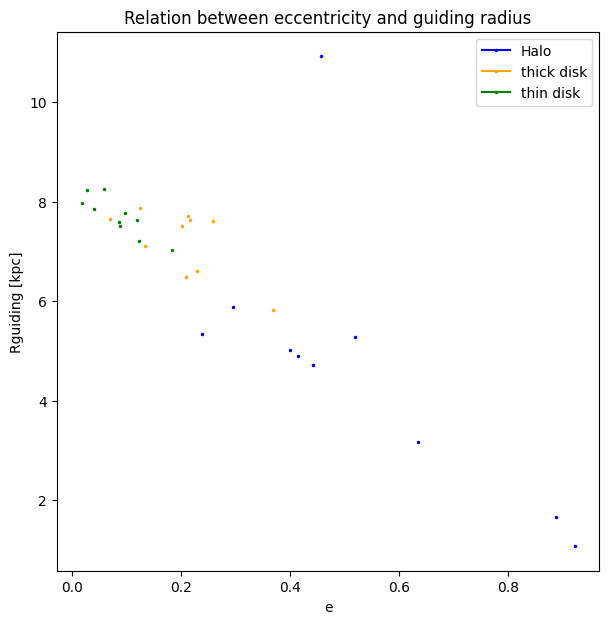

0.9229789607104968 1.0763057694141327


In [ ]:

fig = pl.figure(figsize=(7,7))
fig.subplots_adjust(wspace=0.3)
ax1 = fig.add_subplot(111)

o_h_rg = o_halo.rguiding()
o_t_rg = o_thick.rguiding()
o_ti_rg = o_thin.rguiding()


for i in range(len(o_halo.R())): 
      
     ax1.plot(o_h_e[i], o_h_rg[i], marker='.', ms=3 ,color = 'blue')
     ax1.plot(o_t_e[i], o_t_rg[i], marker='.', ms=3 ,color='orange')
     ax1.plot(o_ti_e[i], o_ti_rg[i], marker='.', ms=3 ,color='green')



ax1.legend(['Halo', 'thick disk', 'thin disk'])
ax1.set_title("Relation between eccentricity and guiding radius")
ax1.set_xlabel('e')
ax1.set_ylabel('Rguiding [kpc]')
pl.show()
print(o_halo.e()[i], o_halo.rguiding()[i])


Guiding center as a function of angular momentum 

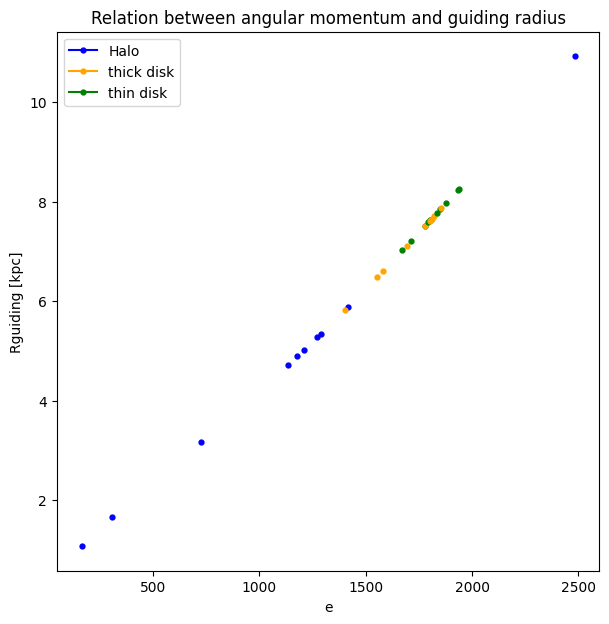

In [ ]:

fig = pl.figure(figsize=(7,7))
fig.subplots_adjust(wspace=0.3)
ax1 = fig.add_subplot(111)

for i in range(len(o_halo.R())): 
      
     ax1.plot(o_h_l[i], o_h_rg[i], marker='.', ms=7 ,color = 'blue')
     ax1.plot(o_t_l[i], o_t_rg[i], marker='.', ms=7 ,color='orange')
     ax1.plot(o_ti_l[i], o_ti_rg[i], marker='.', ms=7, color='green')

ax1.legend(['Halo', 'thick disk', 'thin disk'])
ax1.set_title("Relation between angular momentum and guiding radius") 
ax1.set_xlabel('e')
ax1.set_ylabel('Rguiding [kpc]')
pl.show()


In [ ]:
# Play sound when this line is executed
winsound.PlaySound("sound.wav", winsound.SND_FILENAME)
winsound.PlaySound("sound.wav", winsound.SND_FILENAME)
winsound.PlaySound("sound.wav", winsound.SND_FILENAME)